In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import MousePosition
from pyproj import Proj, Transformer
import json

In [4]:
# 한글깨짐 방지
plt.rc("font", family = "Malgun GOthic")
plt.rc("axes", unicode_minus=False)
import matplotlib
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')


데이터 정의

- YM : 기준년월
- SIDO : 지역대분류명
- SIGUNGU : 지역중분류명
- FranClass : 소상공인구분
- Type : 업종명
- Time : 시간대
- TotalSpent : 총사용금액
- DisSpent : 재난지원금 사용금액
- NumOfSpent : 총 이용건수
- NumOfDisSpent : 총 재난지원금 이용건수
- POINT_X, POINT_Y : X,Y 좌표

# 제주도 재난지원금 데이터 이전의 읍면동별 카드 소비 분석
- 재난지원금의 데이터는 20년 5월~8월, 그래서 그 전인 20년 1~4월로 카드결제 금액으로 소비 분석

In [13]:
# 커드 데이터 가져오기
card = pd.read_csv('카드 매출액 변화 데이터.csv', encoding='ansi')
card.shape

(90543, 11)

In [14]:
card.head()

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,근무인구,방문인구,데이터기준일자
0,2017-01,서귀포시,남원읍,건강보조식품 소매업,남성,11,137500,4365500.518,380992.059,2844836.615,2020-12-15
1,2017-01,서귀포시,남원읍,골프장 운영업,남성,1988,285901584,4365500.518,380992.059,2844836.615,2020-12-15
2,2017-01,서귀포시,남원읍,과실 및 채소 소매업,남성,685,49486002,4365500.518,380992.059,2844836.615,2020-12-15
3,2017-01,서귀포시,남원읍,관광 민예품 및 선물용품 소매업,남성,6,116000,4365500.518,380992.059,2844836.615,2020-12-15
4,2017-01,서귀포시,남원읍,그외 기타 종합 소매업,남성,1,100000,4365500.518,380992.059,2844836.615,2020-12-15


In [15]:
card.tail()

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,근무인구,방문인구,데이터기준일자
90538,2020-04,제주시,화북동,체인화 편의점,여성,4912,38606200,9241265.99,481026.216,2598152.464,2020-12-15
90539,2020-04,제주시,화북동,택시 운송업,여성,29,211680,9241265.99,481026.216,2598152.464,2020-12-15
90540,2020-04,제주시,화북동,"피자, 햄버거, 샌드위치 및 유사 음식점업",여성,1193,17417160,9241265.99,481026.216,2598152.464,2020-12-15
90541,2020-04,제주시,화북동,한식 음식점업,여성,4632,149658745,9241265.99,481026.216,2598152.464,2020-12-15
90542,2020-04,제주시,화북동,화장품 및 방향제 소매업,여성,163,14553710,9241265.99,481026.216,2598152.464,2020-12-15


In [16]:
# 17년도 부터 있으니 필요한 20년 1월~4월 빼고 제거
card = card[card["년월"].str.contains("2020")]
card.head()

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,근무인구,방문인구,데이터기준일자
81567,2020-01,서귀포시,남원읍,건강보조식품 소매업,남성,2,65000,4869067.386,444319.725,3304302.997,2020-12-15
81568,2020-01,서귀포시,남원읍,골프장 운영업,남성,1980,297727940,4869067.386,444319.725,3304302.997,2020-12-15
81569,2020-01,서귀포시,남원읍,과실 및 채소 소매업,남성,1429,59655253,4869067.386,444319.725,3304302.997,2020-12-15
81570,2020-01,서귀포시,남원읍,관광 민예품 및 선물용품 소매업,남성,74,1730000,4869067.386,444319.725,3304302.997,2020-12-15
81571,2020-01,서귀포시,남원읍,그외 기타 종합 소매업,남성,1,100000,4869067.386,444319.725,3304302.997,2020-12-15


In [17]:
card.shape

(8976, 11)

In [23]:
card.groupby(['년월']).sum()

,이용자수,이용금액,거주인구,근무인구,방문인구
년월,,,,,
2020-01,3938776,138167118226,1.084438e+10,1.125537e+09,6.979003e+09
2020-02,3180770,101657255580,1.041415e+10,9.977364e+08,5.302893e+09
2020-03,3306862,102934625430,1.175674e+10,1.034136e+09,5.207861e+09
2020-04,3443416,107121260529,1.128469e+10,9.385870e+08,4.981342e+09


In [21]:
# 월별 소비분석
price = card.groupby(["년월"]).sum().이용금액

In [22]:
price

년월
2020-01    138167118226
2020-02    101657255580
2020-03    102934625430
2020-04    107121260529
Name: 이용금액, dtype: int64

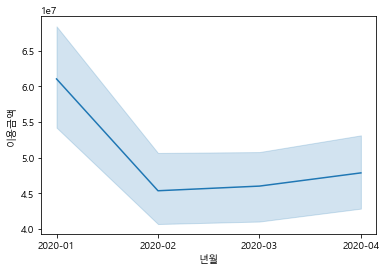

In [26]:
sns.lineplot(y='이용금액', x='년월', data=card)

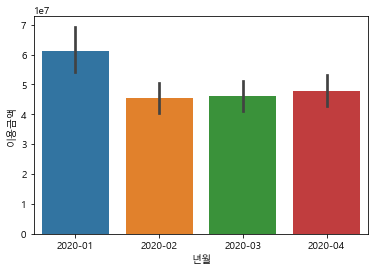

In [30]:
sns.barplot(y='이용금액', x='년월', data=card)

코로나가 시작할때쯤 낮아졌다가 다시 증가한것같다

In [39]:
card.groupby('업종명').sum().이용금액.to_frame().reset_index().sort_values(by='이용금액', ascending=False)[:10]

,업종명,이용금액
36,한식 음식점업,99616018289
19,슈퍼마켓,51168020405
32,차량용 주유소 운영업,42112272500
33,체인화 편의점,35281987673
7,기타 대형 종합 소매업,21346220866
11,기타음식료품위주종합소매업,19331179610
14,면세점,18886618997
25,일반유흥 주점업,14159755021
20,스포츠 및 레크레이션 용품 임대업,12756960944
17,서양식 음식점업,12723045067


업종별로 이용금액 많은수 top10

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

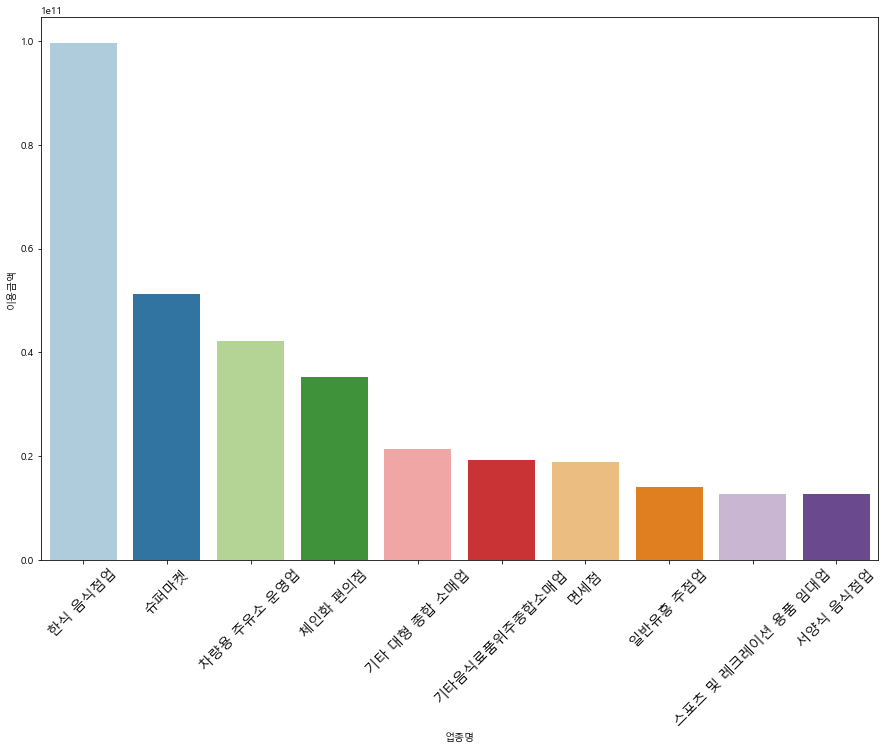

In [40]:
plt.figure(figsize=(15,10))
sns.barplot(data=card.groupby('업종명').sum().이용금액.to_frame().reset_index().sort_values(by='이용금액', ascending=False)[:10], x='업종명', y='이용금액', palette='Paired')
plt.xticks(rotation=45, size=14)

In [42]:
# 유동인구별, 이용금액 20년도 데이터만
place = pd.read_csv("인기있는 업종 추천 데이터.csv", encoding='ansi')
place.head()

,년월,시도명,읍면동명,업종명,이용자수,이용금액,총 유동인구,데이터기준일자
0,2018-01,서귀포시,남원읍,건강보조식품 소매업,7,789000,15559582.61,2020-12-15
1,2018-01,서귀포시,남원읍,골프장 운영업,3277,484029251,15559582.61,2020-12-15
2,2018-01,서귀포시,남원읍,과실 및 채소 소매업,1251,103272305,15559582.61,2020-12-15
3,2018-01,서귀포시,남원읍,관광 민예품 및 선물용품 소매업,147,5320500,15559582.61,2020-12-15
4,2018-01,서귀포시,남원읍,그외 기타 종합 소매업,9,5640000,15559582.61,2020-12-15


In [43]:
place = place[place['년월'].str.contains('2020')]
place.head()

,년월,시도명,읍면동명,업종명,이용자수,이용금액,총 유동인구,데이터기준일자
28310,2020-01,서귀포시,남원읍,건강보조식품 소매업,10,1475000,16801997.61,2020-12-15
28311,2020-01,서귀포시,남원읍,골프장 운영업,3929,727062477,16801997.61,2020-12-15
28312,2020-01,서귀포시,남원읍,과실 및 채소 소매업,3313,159828593,16801997.61,2020-12-15
28313,2020-01,서귀포시,남원읍,관광 민예품 및 선물용품 소매업,366,6843000,16801997.61,2020-12-15
28314,2020-01,서귀포시,남원읍,그외 기타 종합 소매업,12,5210000,16801997.61,2020-12-15


## 읍면동별 이용금액

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

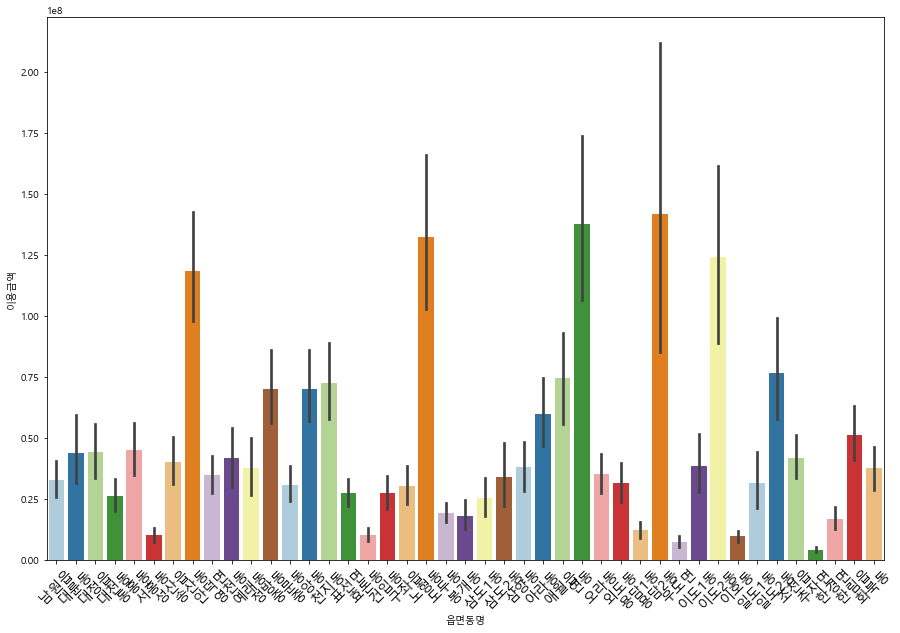

In [47]:
plt.figure(figsize=(15,10))
sns.barplot(x='읍면동명', y='이용금액', data = card, palette = 'Paired')
plt.xticks(rotation=45, size=14)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

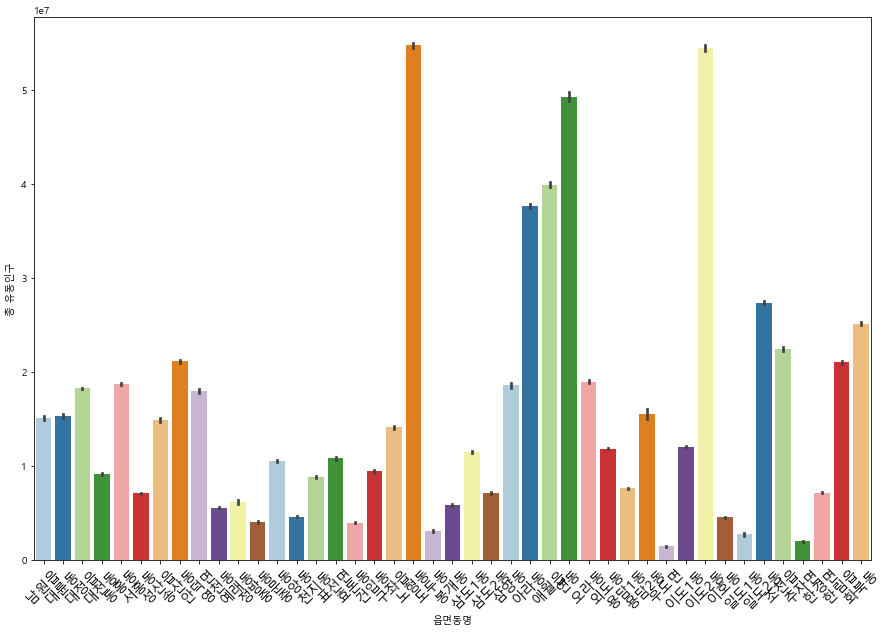

In [50]:
# 유동인구가 많은 지역 소비금액 확인
plt.figure(figsize=(15,10))
sns.barplot(data = place, y='총 유동인구', x='읍면동명', palette='Paired')
plt.xticks(rotation=45, size=14)

In [70]:
# 유동인구 대비 소비금액
temp = place.groupby('읍면동명').sum()
temp['유동인구대비소비금액'] = temp['이용금액'] / temp['총 유동인구']
temp.reset_index().head()

,읍면동명,이용자수,이용금액,총 유동인구,유동인구대비소비금액
0,건입동,210074,8336112219,1.059961e+09,7.864546
1,구좌읍,249118,8499987560,1.554873e+09,5.466678
2,남원읍,232930,10446920083,1.690815e+09,6.178631
3,노형동,1401507,49623229156,7.442107e+09,6.667900
4,대륜동,305776,11935673521,1.658275e+09,7.197645


In [77]:
temp.sort_values(by='총 유동인구', ascending=False)

,이용자수,이용금액,총 유동인구,유동인구대비소비금액
읍면동명,,,,
노형동,1401507,49623229156,7.442107e+09,6.667900
연동,1192524,57433741256,6.650776e+09,8.635645
이도2동,1169473,40365306813,6.645690e+09,6.073908
애월읍,639370,24371535811,5.111164e+09,4.768295
아라동,666501,17699636136,4.145900e+09,4.269190
일도2동,566225,21065184161,3.067710e+09,6.866745
조천읍,424016,14565366953,2.896719e+09,5.028229
화북동,313173,9914738913,2.640346e+09,3.755090
송산동,969143,37746595664,2.625388e+09,14.377528


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

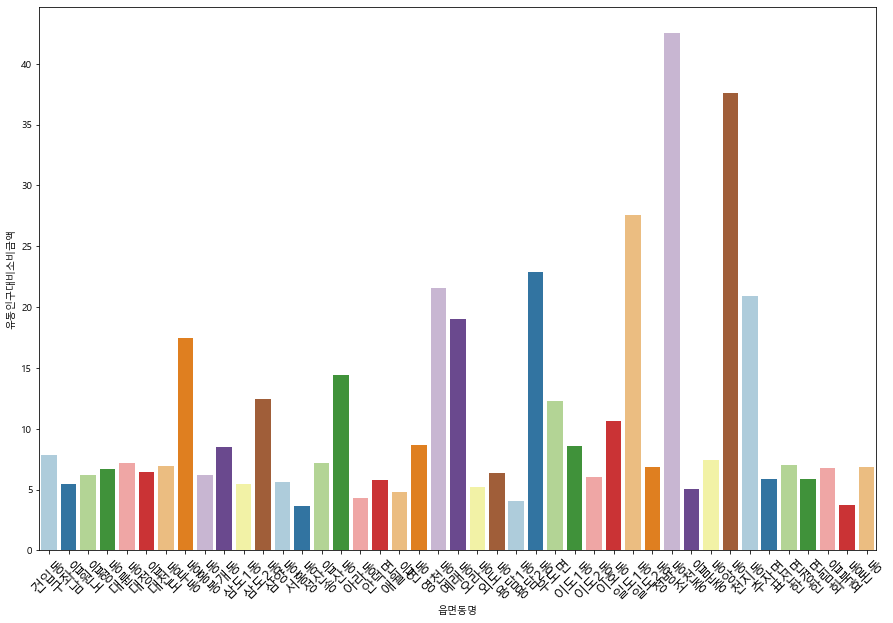

In [63]:
plt.figure(figsize=(15,10))
sns.barplot(data=temp, x=temp.index, y='유동인구대비소비금액', palette='Paired')
plt.xticks(rotation=45, size=14)

 유동인구가 많다고 소비금액이 많은건 아니다

In [12]:
data5 = pd.read_csv('jeju_data5.txt', engine='python', encoding='utf-8')

In [13]:
data6 = pd.read_csv('jeju_data6.txt', engine='python', encoding='utf-8')

In [22]:
data7 = pd.read_csv('jeju_data7.txt', engine='python', encoding='utf-8')

In [15]:
data8 = pd.read_csv('jeju_data8.txt', engine='python', encoding='utf-8')

In [7]:
data5.head()

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,1,1,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,877005.9834,1.479766e+06
1,2,2,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,877005.7447,1.479816e+06
2,3,3,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,877056.6756,1.479616e+06
3,4,4,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,877055.9593,1.479766e+06
4,5,5,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,877055.4817,1.479866e+06


In [16]:
data5.shape, data6.shape, data7.shape, data8.shape

((273183, 14), (281896, 14), (284265, 16), (280085, 14))

In [17]:
data7.head()

,OBJECTID,Field1,YM,SIDO,SIGUNGU,X,Y,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,1,1,202007,제주특별자치도,제주시,230600,80000,영세,일반한식,00시,85500,0,4,0,877005.9834,1.479766e+06
1,2,2,202007,제주특별자치도,제주시,230600,80050,영세,단란주점,00시,1960000,0,4,0,877005.7447,1.479816e+06
2,3,3,202007,제주특별자치도,제주시,230650,79850,중소1,편의점,00시,475650,0,43,0,877056.6756,1.479616e+06
3,4,4,202007,제주특별자치도,제주시,230650,80000,영세,편의점,00시,15650,0,1,0,877055.9593,1.479766e+06
4,5,5,202007,제주특별자치도,제주시,230650,80100,영세,주점,00시,82500,0,1,0,877055.4817,1.479866e+06


In [25]:
data7 = data7.drop(['X','Y'], axis=1)

In [26]:
data7

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,1,1,202007,제주특별자치도,제주시,영세,일반한식,00시,85500,0,4,0,877005.9834,1.479766e+06
1,2,2,202007,제주특별자치도,제주시,영세,단란주점,00시,1960000,0,4,0,877005.7447,1.479816e+06
2,3,3,202007,제주특별자치도,제주시,중소1,편의점,00시,475650,0,43,0,877056.6756,1.479616e+06
3,4,4,202007,제주특별자치도,제주시,영세,편의점,00시,15650,0,1,0,877055.9593,1.479766e+06
4,5,5,202007,제주특별자치도,제주시,영세,주점,00시,82500,0,1,0,877055.4817,1.479866e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284260,284261,284261,202007,제주특별자치도,제주시,영세,기념품점,x시,6000,0,1,0,950524.6587,1.500760e+06
284261,284262,284262,202007,제주특별자치도,제주시,중소,농축수산품,x시,20000,0,1,0,950524.6587,1.500760e+06
284262,284263,284263,202007,제주특별자치도,제주시,중소,제과점,x시,30000,0,2,0,950524.6587,1.500760e+06
284263,284264,284264,202007,제주특별자치도,제주시,중소1,중국음식,x시,13000,0,1,0,950574.6388,1.500760e+06
